In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import cv2
random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/Animals/animals"
animals = os.listdir(dataset_path)
print(animals)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['dogs', 'panda', 'cats']


Load the dataset form google drive

Selecting 1000 images from each class for balanced dataset.

In [5]:
selected_images = {}
for animal in animals:
  animal_path = os.path.join(dataset_path, animal)
  images = os.listdir(animal_path)
  if len(images) >= 3000:
    selected_images[animal] = random.sample(images, 3000)
  else:
    print(f"Class {animal} has less than 3000 images. Selecting all {len(images)} images.")
    selected_images[animal] = images

Class dogs has less than 3000 images. Selecting all 100 images.
Class panda has less than 3000 images. Selecting all 100 images.
Class cats has less than 3000 images. Selecting all 100 images.


Initiating image properties and train_data size.

In [6]:
image_size = 32
images_count = 100
k_values = list(range(2, 20))

Suffile all 3000 images and randomly selecting **100** images to train

In [ ]:
train_imgs = []

for index, animal in enumerate(animals):
    label = index
    path = os.path.join(dataset_path, animal)
    images = os.listdir(path)
    random.shuffle(images)

    for img in images[:images_count]:
        img_path = os.path.join(path, img)
        img_bgr = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (image_size, image_size))
        train_imgs.append([img_gray, label])

np.random.shuffle(train_imgs)

Viewing the images with label to varify

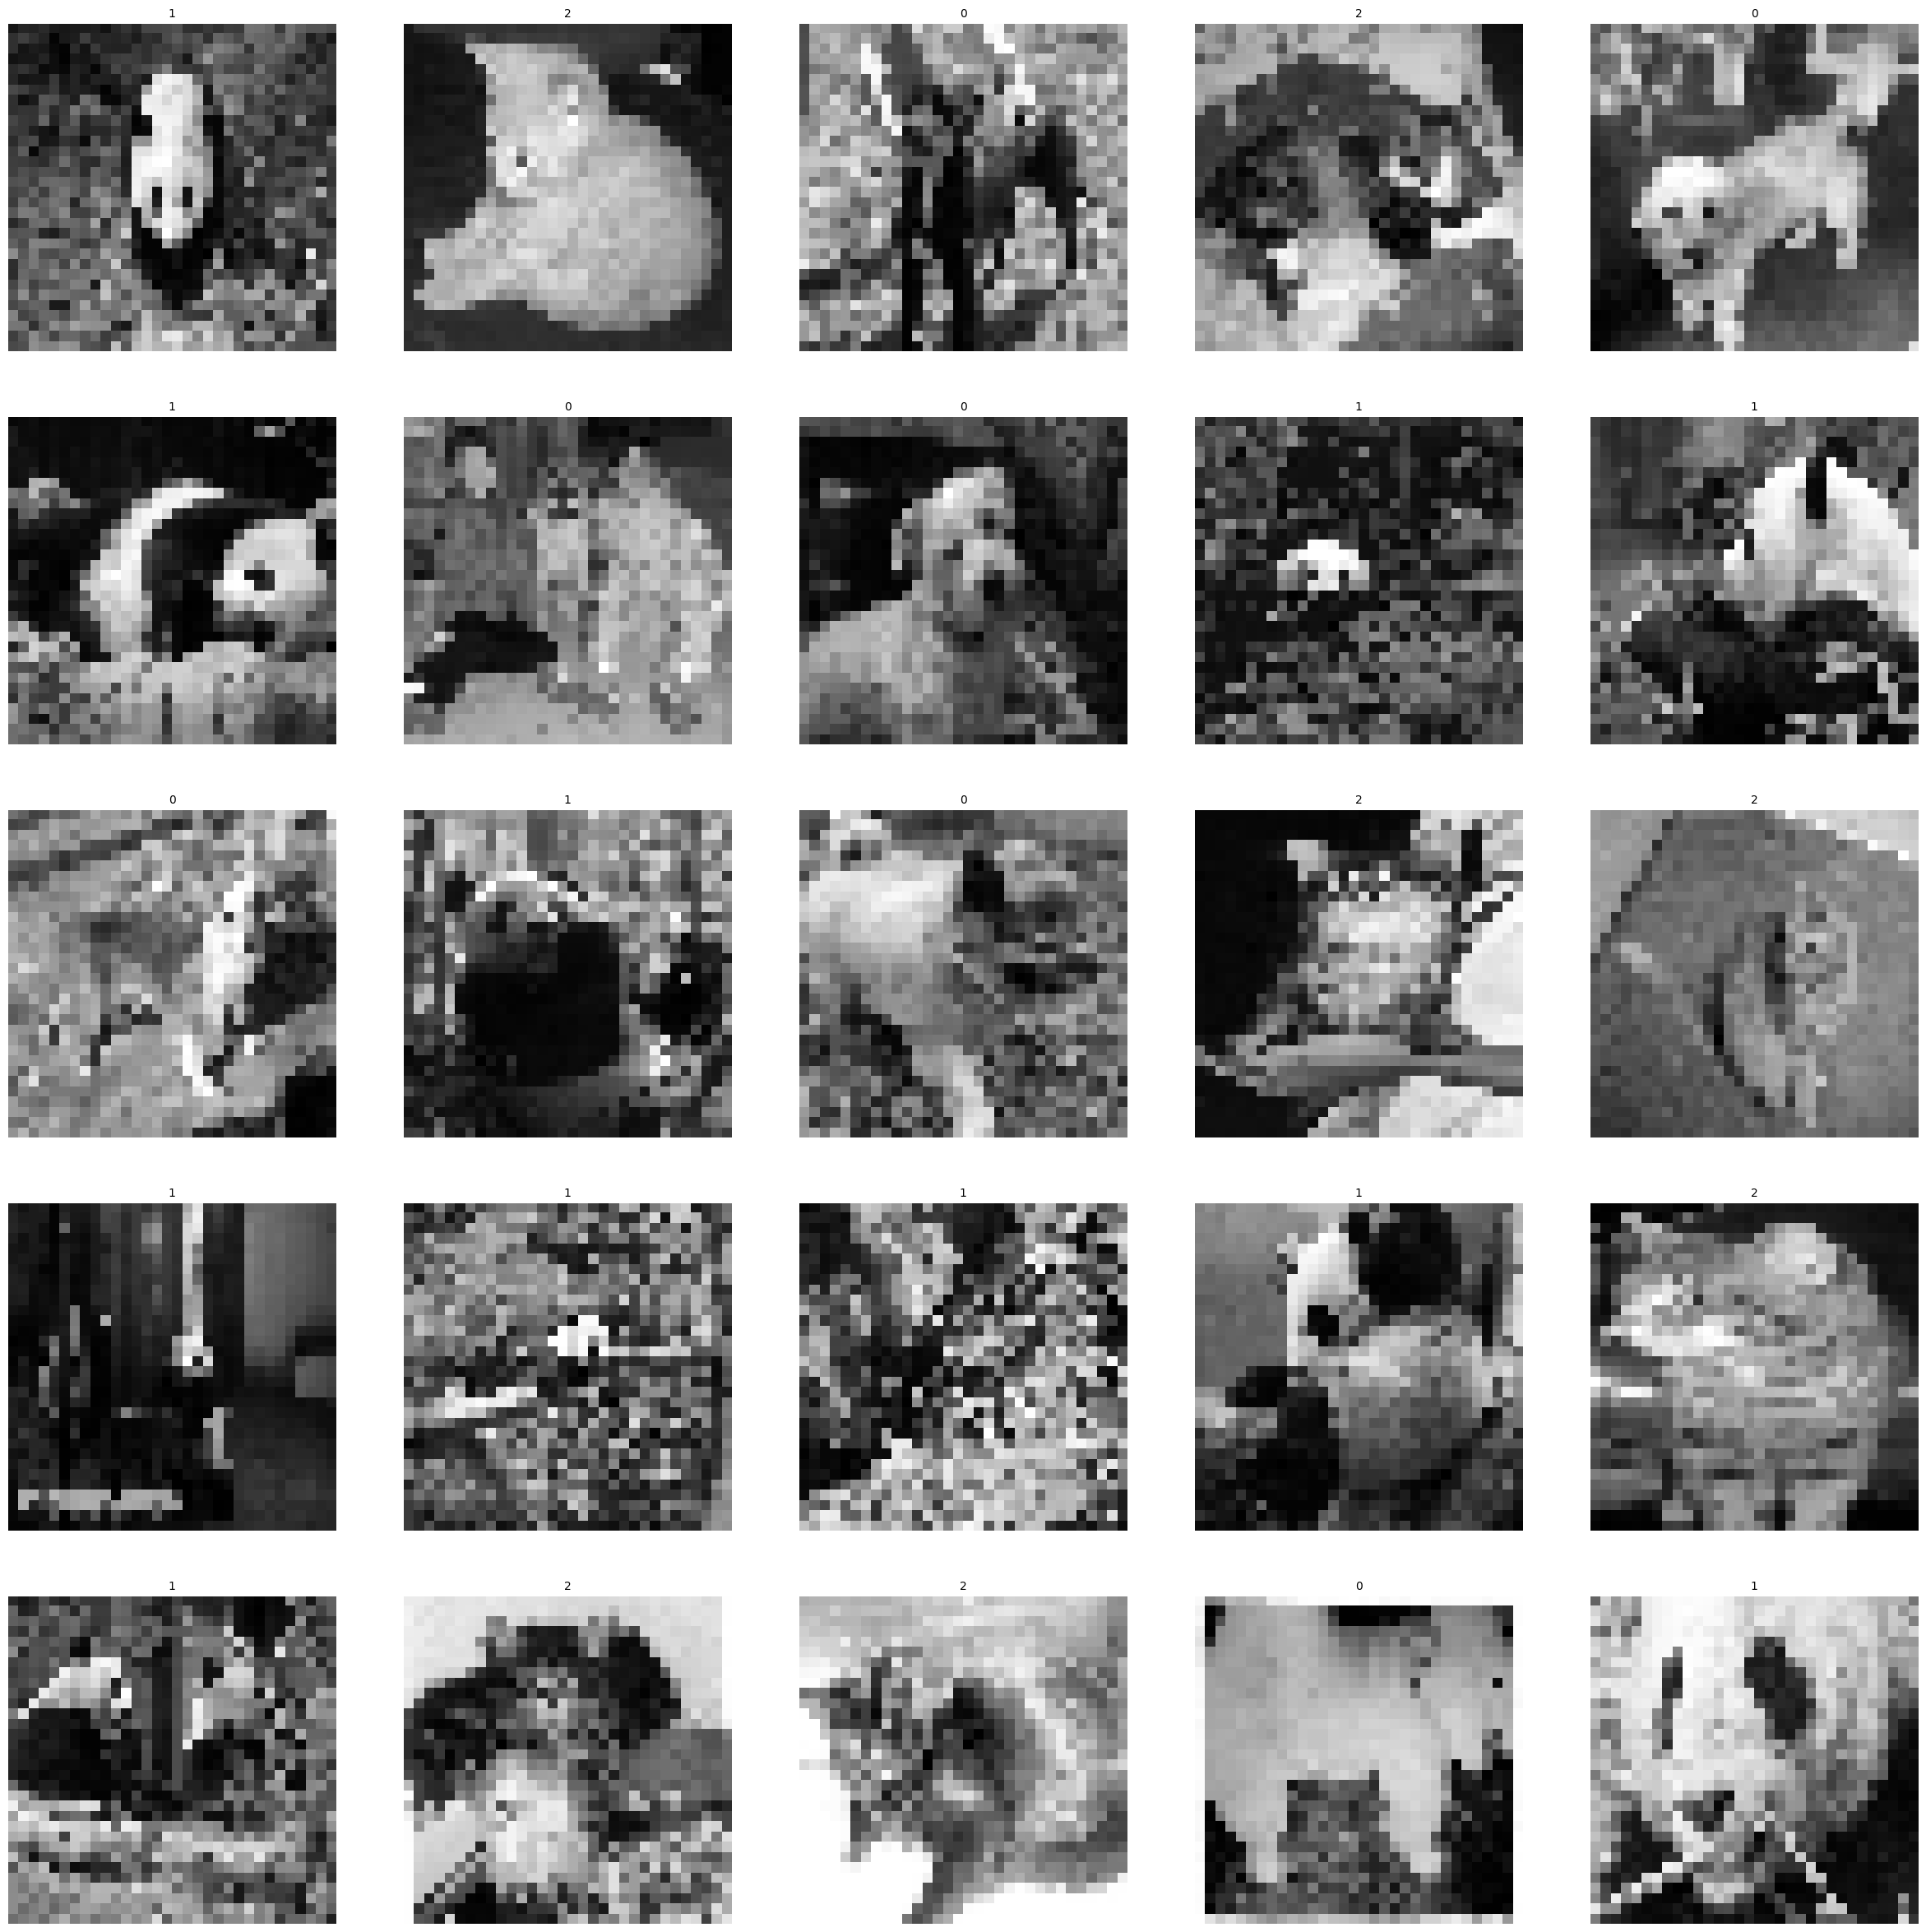

In [8]:
rows, cols = 5, 5
plt.figure(figsize=(30, 30))

for i in range(rows * cols):
    img, label = train_imgs[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.show()

Defining L1 and L2 distance functions

In [9]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [10]:
def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

In [11]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

Comparison between L1 and L2 distance

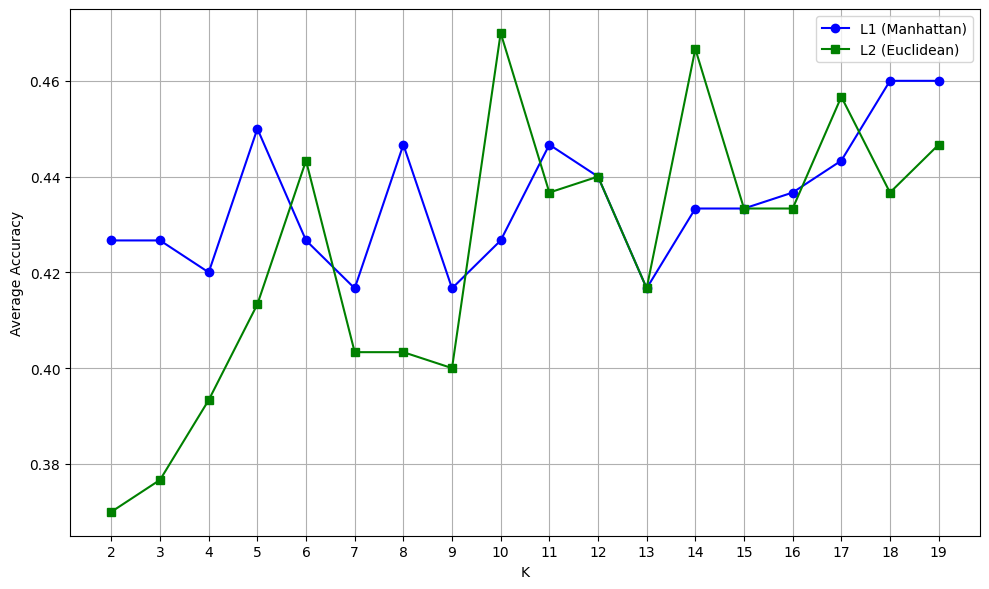

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='green')

plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(k_values)  # Ensure integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Here, Manhattan (L1) and Euclidean (L2) distance measures are compared on the basis of their performance with 5-fold cross-validation on grayscale image data. The primary goal was to compare which measure provided more classification accuracy and to discuss the reasons for differences in performance. Based on the cross-validation result derived, it was observed that the Euclidean distance always provided a higher average classification accuracy than Manhattan distance.

One of the explanations for this performance gap is in the type of dataset. Since we are dealing with grayscale images, features are continuous pixel intensity values ranging between 0 to 255. These features tend to be dense with smooth transitions, and such features are best suited with the L2 norm. The Euclidean distance penalizes large differences more heavily, making it more sensitive to the detection of small pixel pattern differences crucial for correct classification. The L1 distance, which merely computes the sum of absolute differences across all features, will be more robust in cases involving sparse data or outliers—cases that are not true for our dataset in question.

Also, the complexity of the classes may have had an impact. If there exists some redundancy in the feature space between classes, the L2 distance can provide greater discrimination by increasing the separation of close feature vectors. This makes Euclidean distance more appropriate for this specific task, where the geometric relationships between pixels must be preserved for the separation of classes.

Despite the better performance of the L2 metric, it still has some limitations and areas for improvement. For instance, feature normalization techniques, such as min-max scaling or Z-score standardization, would reduce potential distortions caused by varying pixel ranges.

Showing the top 5 predictions

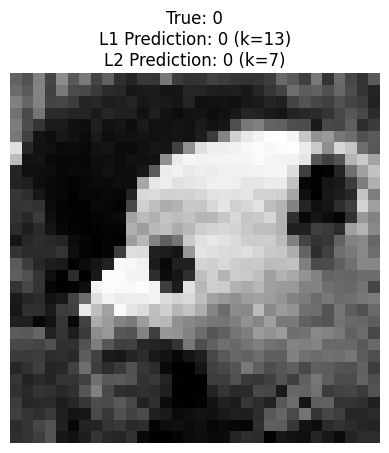

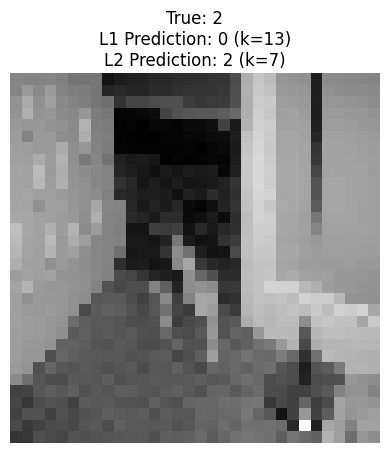

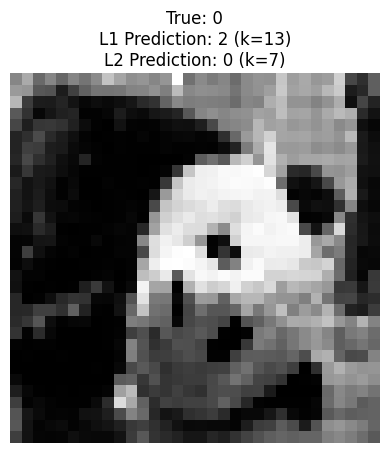

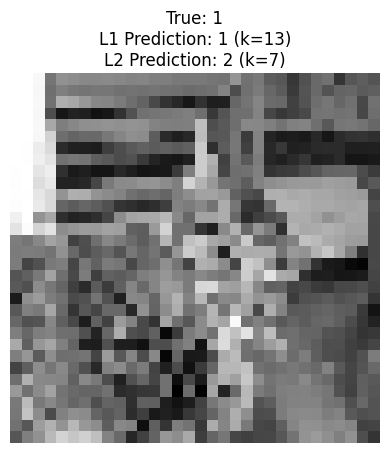

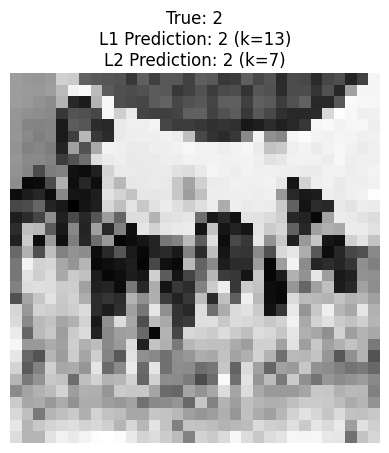

In [ ]:
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = Y[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, Y, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, Y, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {true_label}\n"
        f"L1 Prediction: {pred_l1} (k={best_k_l1})\n"
        f"L2 Prediction: {pred_l2} (k={best_k_l2})"
    )
    plt.show()